# Initialisation

In [2]:
%%time
bucket = 'sagemaker-object-detection-test-200408' # custom bucket name.
# bucket = sess.default_bucket()
prefix = 'ObjectDetection-v0'

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

In [56]:
import os
import urllib.request
import json
import logging
import numpy as np

DATA = []

In [ ]:
%%bash
pip install --upgrade mxnet gluoncv

# Prepare / Download datasets

## COCO

### Download / Unpack

In [5]:
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


# MSCOCO validation image files
download('http://images.cocodataset.org/zips/val2017.zip')
download('http://images.cocodataset.org/annotations/annotations_trainval2017.zip')

In [6]:
%%bash
mkdir -p data/coco || true
mv val2017.zip data/coco
mv annotations_trainval2017.zip data/coco
cd data/coco
unzip -qo val2017.zip || true
unzip -qo annotations_trainval2017.zip || true
rm val2017.zip annotations_trainval2017.zip || true
cd ../..

#Create folders to store the data and annotation files
#cd data/coco
#rm -rf generated train train_annotation validation validation_annotation || true
#mkdir generated train train_annotation validation validation_annotation || true

In [24]:
### Prepare Mappers

COCO_CAT_IDS [17]
COCO_DOG_IDS [18]


In [25]:
COCO_CAT_IDS = []
COCO_DOG_IDS = []

file_name = './data/coco/annotations/instances_val2017.json'
with open(file_name) as f:
    js = json.load(f)
    images = js['images']
    categories = js['categories']
    for c in categories:
        n = c['name']
        i = c['id']
        if n == 'cat':
            COCO_CAT_IDS.append(i)
        if n == 'dog':
            COCO_DOG_IDS.append(i)
            
print("COCO_CAT_IDS %s" % COCO_CAT_IDS)
print("COCO_DOG_IDS %s" % COCO_DOG_IDS)

def is_cat_or_dog(category):
    if category in COCO_CAT_IDS or category in COCO_CAT_IDS:
        return True
    return False

#def get_coco_mapper():
#    original_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
#                    21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
#                    41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
#                    61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80,
#                    81, 82, 84, 85, 86, 87, 88, 89, 90]
#    iter_counter = 0
#    COCO = {}
#    for orig in original_list:
#        if is_cat_or_dog(orig):
#            COCO[orig] = iter_counter
#            iter_counter += 1
#    return COCO

#def get_mapper_fn(map):  
#    def mapper(in_category):
#        return map[in_category]
#    return mapper

#fix_index_mapping = get_mapper_fn(get_coco_mapper())

def fix_index_mapping(map):
    if map in COCO_DOG_IDS:
        return 0
    if map in COCO_CAT_IDS:
        return 1
 

In [57]:
### Register Images from COCO dataset


def load_annotations_from(file_name, root_dir):
    ret = list()
    with open(file_name) as f:
        js = json.load(f)
        images = js['images']
        categories = js['categories']
        annotations = js['annotations']
        
        annotation_dict = dict()
        for a in annotations:
            image_id = a['image_id']
            if image_id not in annotation_dict:
                annotation_dict[image_id] = list()
                
            annotation_dict[image_id].append(a)
                
        for i in images:
            jsonFile = i['file_name']
            jsonFile = jsonFile.split('.')[0]+'.json'

            line = {}
            line['file'] = root_dir + '/' + i['file_name'] # <<<< needed
            line['image_size'] = [int(i['height']), int(i['width']), 3] # <<<< needed
            line['annotations'] = []
            line['ids'] = []
            line['boxes'] = []
            if i['id'] not in annotation_dict:
                # There are pictures with no annotations(!)
                continue
            for j in annotation_dict[i['id']]:
                if j['image_id'] == i['id'] and len(j['bbox']) > 0:
                    if not is_cat_or_dog(j['category_id']):
                        continue

                    line['annotations'].append({
                        'class_id': fix_index_mapping(j['category_id']),
                        'top':int(j['bbox'][1]),
                        'left':int(j['bbox'][0]),
                        'width':int(j['bbox'][2]),
                        'height':int(j['bbox'][3])
                    })
                    line['boxes'].append([j['bbox'][0], j['bbox'][1], j['bbox'][2], j['bbox'][3]]) # <<<< needed
                    line['ids'].append(fix_index_mapping(j['category_id'])) # <<<< needed
            if line['annotations']:
                ret.append(line)
    return ret

coco_val_annot = load_annotations_from('./data/coco/annotations/instances_val2017.json', './data/coco/val2017')
for a in coco_val_annot:
    DATA.append(a)

In [60]:
# Split Data into train/val

Train data 165 , val data 19


In [62]:
length = len(DATA)
amount_train = 0.9

split_idx = int(length*amount_train)

TRAIN_DATA = DATA[:split_idx]
VAL_DATA = DATA[split_idx:]

print("Train data", len(TRAIN_DATA), ", val data", len(VAL_DATA))

def create_line(img_path, im_shape, boxes, ids, idx):
    """ FROM https://gluon-cv.mxnet.io/build/examples_datasets/detection_custom.html """
    h, w, c = im_shape
    # for header, we use minimal length 2, plus width and height
    # with A: 4, B: 5, C: width, D: height
    A = 4
    B = 5
    C = w
    D = h
    # concat id and bboxes
    labels = np.hstack((ids.reshape(-1, 1), boxes)).astype('float')
    # normalized bboxes (recommanded)
    labels[:, (1, 3)] /= float(w)
    labels[:, (2, 4)] /= float(h)
    # flatten
    labels = labels.flatten().tolist()
    str_idx = [str(idx)]
    str_header = [str(x) for x in [A, B, C, D]]
    str_labels = [str(x) for x in labels]
    str_path = [img_path]
    line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
    return line

def write_lst(annot, out, idx_start=0):
    idx = idx_start
    with open(out, 'w+') as f:
        for a in annot:
            line = create_line(a['file'], np.array(a['image_size']), np.array(a['boxes']), np.array(a['ids']), idx)
            f.write(line)
            idx += 1
    return idx

write_lst(TRAIN_DATA, "train.lst", 0)
write_lst(VAL_DATA, "val.lst", 0)

In [17]:
%%time
%%bash
./im2rec.py 'train.lst' '.' --resize 512 --pack-label --num-thread 2
./im2rec.py 'val.lst' '.' --resize 512 --pack-label --num-thread 2

Creating .rec file from /home/ec2-user/SageMaker/ubiquitous-adventure/v1/train.lst in /home/ec2-user/SageMaker/ubiquitous-adventure/v1
time: 0.0782325267791748  count: 0
Creating .rec file from /home/ec2-user/SageMaker/ubiquitous-adventure/v1/val.lst in /home/ec2-user/SageMaker/ubiquitous-adventure/v1
time: 0.0835564136505127  count: 0
CPU times: user 0 ns, sys: 11.7 ms, total: 11.7 ms
Wall time: 7.22 s


# Test Read first image of each dataset

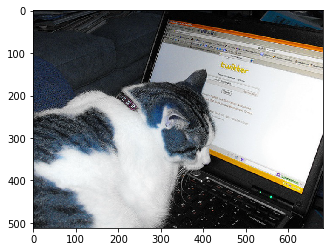

In [18]:
import mxnet as mx
from matplotlib.pyplot import imshow
%matplotlib inline

record = mx.recordio.MXIndexedRecordIO('val.idx', 'val.rec', 'r')
for i in range(1):
    item = record.read()
    header, s = mx.recordio.unpack_img(item)

imshow(s)

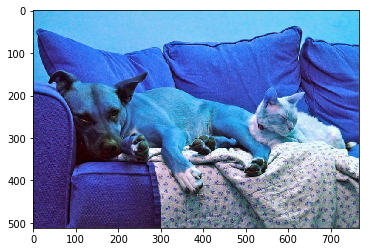

In [19]:
record = mx.recordio.MXIndexedRecordIO('train.idx', 'train.rec', 'r')
for i in range(1):
    item = record.read()
    header, s = mx.recordio.unpack_img(item)

imshow(s)

# Upload to S3 - TODO (!)

In [4]:
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)


In [5]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
s3_output_location

's3://sagemaker-object-detection-test-200408/ObjectDetection-v0/output'